# 02.2 The Ideal Experiment & Assignment Mechanisms

**Chapter**: 2 - Randomised Experiments  
**Section**: 2 - The Ideal Experiment  
**Facure Source**: 02-Randomised-Experiments.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [When RCTs Aren't Possible](#11-when-rcts-arent-possible)
   - 1.2 [The Ideal Experiment Thought Exercise](#12-the-ideal-experiment-thought-exercise)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Assignment Mechanisms](#21-assignment-mechanisms)
   - 2.2 [Known vs Unknown Mechanisms](#22-known-vs-unknown-mechanisms)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Different Assignment Mechanisms](#31-different-assignment-mechanisms)
   - 3.2 [Why Mechanism Matters](#32-why-mechanism-matters)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from scipy.special import expit

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Articulating the "ideal experiment" demonstrates causal thinking. It's the mental model for understanding natural experiments and quasi-experiments.

### 1.1 When RCTs Aren't Possible

Facure identifies three barriers to RCTs:

**1. Unethical**
- Can't randomize smoking during pregnancy to study birth weight
- Can't randomize violence exposure to study trauma

**2. Expensive**
- Randomizing credit lines costs money (defaults on inflated lines)
- Large-scale policy experiments require government resources

**3. Infeasible**
- Can't randomize countries to different minimum wages
- Can't randomize historical events

### 1.2 The Ideal Experiment Thought Exercise

Facure's advice: **Always ask: "What is the perfect experiment I would run if I could?"**

This clarifies:
1. What treatment you're actually studying
2. What population you care about
3. What confounders might exist
4. What observational strategy might approximate the ideal

★ Insight ─────────────────────────────────────
- The ideal experiment is a thought tool, not a requirement
- Natural experiments approximate ideal experiments
- Identification strategies exploit "as good as random" variation
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Assignment Mechanisms

The **assignment mechanism** describes how units receive treatment:

$$P(T | X, Y_0, Y_1)$$

**Types of assignment mechanisms**:

| Mechanism | Formula | Example |
|-----------|---------|--------|
| **Random** | $P(T) = p$ (constant) | Coin flip |
| **Selection on observables** | $P(T|X)$ | Rich schools buy tablets |
| **Selection on unobservables** | $P(T|X, U)$ | Motivated students seek tutoring |
| **Selection on outcomes** | $P(T|Y_0, Y_1)$ | Sick patients get treatment |

**Key insight**: Causal inference requires understanding (or controlling) the assignment mechanism.

### 2.2 Known vs Unknown Mechanisms

**When mechanism is known**:
- RCT: Mechanism is designed (coin flip)
- Regression discontinuity: Mechanism is rule-based (cutoff)
- Natural experiment: Mechanism exploits policy variation

**When mechanism is unknown**:
- Must make assumptions
- Conditional ignorability: $(Y_0, Y_1) \perp T | X$
- Sensitivity analysis tests assumption violations

**Facure's point**: The assignment mechanism cannot be discovered from data alone—it requires domain knowledge.

---

## 3. Numeric Demonstration

### 3.1 Different Assignment Mechanisms

In [2]:
# Simulate data with known potential outcomes
np.random.seed(42)
n = 2000

# Confounder: wealth (affects both treatment and outcome)
wealth = np.random.lognormal(4, 0.5, n)  # Right-skewed

# True treatment effect = +5 (treatment helps)
true_ate = 5

# Potential outcomes depend on wealth
Y0 = 50 + 0.01 * wealth + np.random.normal(0, 10, n)
Y1 = Y0 + true_ate

print("BASE DATA STRUCTURE")
print("="*50)
print(f"Sample size: n = {n}")
print(f"True ATE: {true_ate}")
print(f"Wealth range: [{wealth.min():.0f}, {wealth.max():.0f}]")

BASE DATA STRUCTURE
Sample size: n = 2000
True ATE: 5
Wealth range: [11, 375]


In [3]:
# Compare different assignment mechanisms

def estimate_ate(Y, T):
    """Simple difference in means."""
    return Y[T == 1].mean() - Y[T == 0].mean()

results = []

# Mechanism 1: Random assignment (RCT)
T_random = np.random.binomial(1, 0.5, n)
Y_random = np.where(T_random == 1, Y1, Y0)
ate_random = estimate_ate(Y_random, T_random)
results.append(('Random (RCT)', ate_random, T_random.mean()))

# Mechanism 2: Selection on wealth (rich get treatment)
p_wealth = expit((wealth - wealth.mean()) / wealth.std())
T_wealth = np.random.binomial(1, p_wealth)
Y_wealth = np.where(T_wealth == 1, Y1, Y0)
ate_wealth = estimate_ate(Y_wealth, T_wealth)
results.append(('Selection on Wealth', ate_wealth, T_wealth.mean()))

# Mechanism 3: Selection on Y0 (those with high baseline get treatment)
p_y0 = expit((Y0 - Y0.mean()) / Y0.std())
T_y0 = np.random.binomial(1, p_y0)
Y_y0 = np.where(T_y0 == 1, Y1, Y0)
ate_y0 = estimate_ate(Y_y0, T_y0)
results.append(('Selection on Y0', ate_y0, T_y0.mean()))

# Mechanism 4: Negative selection (those with LOW Y0 get treatment)
p_neg = expit(-(Y0 - Y0.mean()) / Y0.std())
T_neg = np.random.binomial(1, p_neg)
Y_neg = np.where(T_neg == 1, Y1, Y0)
ate_neg = estimate_ate(Y_neg, T_neg)
results.append(('Negative Selection', ate_neg, T_neg.mean()))

print("ASSIGNMENT MECHANISM COMPARISON")
print("="*60)
print(f"{'Mechanism':<25} {'Estimated ATE':>12} {'Treat Rate':>12} {'Bias':>10}")
print("-"*60)
for name, ate, rate in results:
    bias = ate - true_ate
    print(f"{name:<25} {ate:>12.2f} {rate:>12.1%} {bias:>+10.2f}")
print("-"*60)
print(f"{'True ATE':<25} {true_ate:>12.2f}")

ASSIGNMENT MECHANISM COMPARISON
Mechanism                 Estimated ATE   Treat Rate       Bias
------------------------------------------------------------
Random (RCT)                      5.52        48.6%      +0.52
Selection on Wealth               4.85        47.8%      -0.15
Selection on Y0                  13.27        51.4%      +8.27
Negative Selection               -2.87        51.1%      -7.87
------------------------------------------------------------
True ATE                          5.00


### 3.2 Why Mechanism Matters

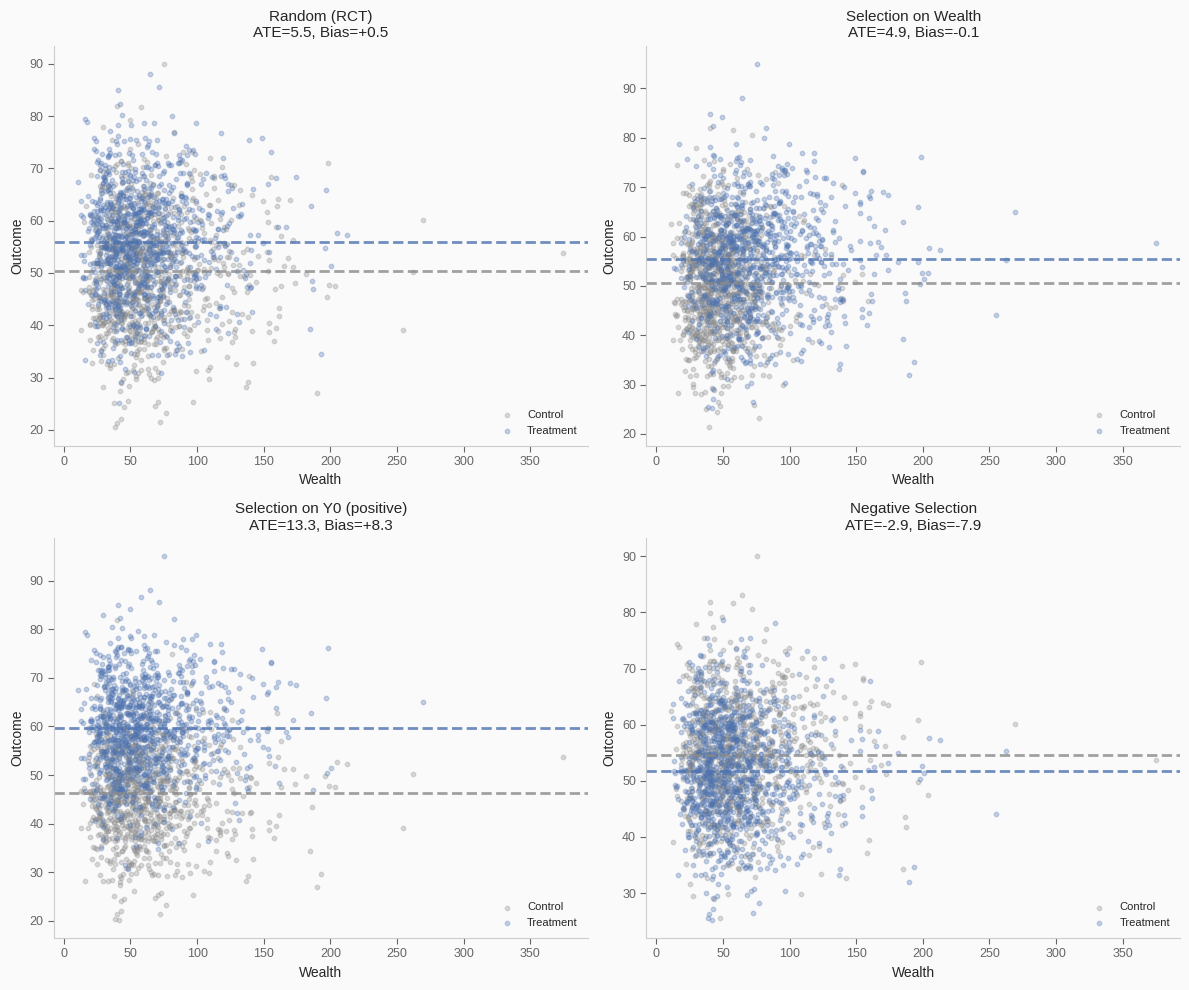

In [4]:
# Visualize how different mechanisms create different problems
fig, axes = create_tufte_figure(2, 2, figsize=(12, 10))

mechanisms = [
    ('Random (RCT)', T_random, Y_random),
    ('Selection on Wealth', T_wealth, Y_wealth),
    ('Selection on Y0 (positive)', T_y0, Y_y0),
    ('Negative Selection', T_neg, Y_neg),
]

for ax, (name, T, Y) in zip(axes.flat, mechanisms):
    # Scatter plot colored by treatment
    ax.scatter(wealth[T == 0], Y[T == 0], alpha=0.3, s=10,
               color=TUFTE_PALETTE['control'], label='Control')
    ax.scatter(wealth[T == 1], Y[T == 1], alpha=0.3, s=10,
               color=TUFTE_PALETTE['treatment'], label='Treatment')
    
    # Add mean lines
    ax.axhline(Y[T == 0].mean(), color=TUFTE_PALETTE['control'], 
               linestyle='--', linewidth=2, alpha=0.8)
    ax.axhline(Y[T == 1].mean(), color=TUFTE_PALETTE['treatment'], 
               linestyle='--', linewidth=2, alpha=0.8)
    
    ate_est = estimate_ate(Y, T)
    bias = ate_est - true_ate
    ax.set_title(f'{name}\nATE={ate_est:.1f}, Bias={bias:+.1f}')
    ax.set_xlabel('Wealth')
    ax.set_ylabel('Outcome')
    ax.legend(frameon=False, loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

In [5]:
# The "ideal experiment" for education → earnings
print("THOUGHT EXERCISE: Education → Earnings")
print("="*60)
print("""
Question: Does a college degree increase earnings?

IDEAL EXPERIMENT:
1. Take population of high school graduates
2. Randomly assign half to attend college (with full funding)
3. Force assigned students to complete degrees
4. Measure earnings 10 years later
5. Compare means: E[Y|College] - E[Y|No College] = ATE

WHY IT'S IMPOSSIBLE:
- Unethical: Can't force education choices
- Expensive: Must fund college for treatment group
- Compliance: Can't force completion
- Time: Need 15+ years to measure outcomes

WHAT OBSERVATIONAL PROBLEMS EXIST:
- Selection on ability: Smart people both go to college AND earn more
- Selection on motivation: Driven people do both
- Selection on wealth: Rich families enable both

POTENTIAL SOLUTIONS:
- RDD: College admission cutoffs
- IV: Distance to college, draft lottery
- DiD: Policy changes in tuition/access
""")

THOUGHT EXERCISE: Education → Earnings

Question: Does a college degree increase earnings?

IDEAL EXPERIMENT:
1. Take population of high school graduates
2. Randomly assign half to attend college (with full funding)
3. Force assigned students to complete degrees
4. Measure earnings 10 years later
5. Compare means: E[Y|College] - E[Y|No College] = ATE

WHY IT'S IMPOSSIBLE:
- Unethical: Can't force education choices
- Expensive: Must fund college for treatment group
- Compliance: Can't force completion
- Time: Need 15+ years to measure outcomes

WHAT OBSERVATIONAL PROBLEMS EXIST:
- Selection on ability: Smart people both go to college AND earn more
- Selection on motivation: Driven people do both
- Selection on wealth: Rich families enable both

POTENTIAL SOLUTIONS:
- RDD: College admission cutoffs
- IV: Distance to college, draft lottery
- DiD: Policy changes in tuition/access



---

## 4. Implementation

Understanding assignment mechanisms guides method choice:

```python
# Step 1: Define the ideal experiment
ideal_experiment = {
    'treatment': 'college_degree',
    'outcome': 'earnings_10yr',
    'population': 'high_school_graduates',
    'assignment': 'random',
}

# Step 2: Identify actual assignment mechanism
actual_mechanism = 'selection_on_ability_and_wealth'

# Step 3: Choose appropriate method
if mechanism == 'random':
    use simple_ate()
elif mechanism == 'selection_on_observables':
    use regression_adjustment() or propensity_score()
elif mechanism == 'rule_based_cutoff':
    use regression_discontinuity()
elif mechanism == 'has_valid_instrument':
    use instrumental_variables()
```

The method must match the mechanism!

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Uber Staff, Econ)**: *"What is an assignment mechanism, and why does it matter for causal inference?"*

<details>
<summary>Solution</summary>

**Definition**: The assignment mechanism describes the probability of treatment as a function of observed/unobserved characteristics:
$$P(T | X, U, Y_0, Y_1)$$

**Why it matters**:

1. **Determines bias**:
   - If $T \perp (Y_0, Y_1)$: No bias (RCT)
   - If $T \not\perp Y_0$: Selection bias exists

2. **Determines valid methods**:
   - Random → Simple difference in means
   - Selection on observables → Regression, matching
   - Selection on unobservables → IV, RDD, DiD needed

3. **Cannot be discovered from data**:
   - Same data can have multiple explanations
   - Need domain knowledge or experimental design

**Example**: If sick people get treatment more often, the naive estimate is biased downward (treatment looks harmful).

</details>

---

**Q2 (Netflix Staff, DS)**: *"Describe a scenario where you'd want to run an A/B test but can't. How would you approach causal inference?"*

<details>
<summary>Solution</summary>

**Scenario**: Estimating the effect of a major UI redesign on subscriber retention.

**Why A/B is hard**:
- UI must be consistent across platform
- Major changes are all-or-nothing
- Contamination: users talk to each other
- Long-term effects require extended experiment

**Alternative approaches**:

1. **Staggered rollout (DiD)**:
   - Roll out to different markets over time
   - Compare early vs. late adopters
   - Assumption: Parallel trends

2. **Geographic discontinuity**:
   - If rollout has geographic boundaries
   - Compare similar users near the boundary

3. **Synthetic control**:
   - If rollout is at market/country level
   - Construct synthetic control from non-treated markets

4. **Interrupted time series**:
   - Before/after with trend adjustment
   - Weakest design, but sometimes only option

**Key**: Think about what creates "as good as random" variation.

</details>

---

**Q3 (Stripe Staff, Applied Scientist)**: *"What is the 'ideal experiment' thought exercise, and how does it help with observational studies?"*

<details>
<summary>Solution</summary>

**The thought exercise**: "If I could run any experiment without constraints, what would it be?"

**How it helps**:

1. **Clarifies the causal question**:
   - What exactly is the treatment? (e.g., "attending college" vs. "having a degree")
   - What is the outcome? (measured when?)
   - Who is the population? (generalizability)

2. **Identifies confounders**:
   - What would randomization balance?
   - These are the confounders you need to worry about

3. **Suggests identification strategies**:
   - What approximates random assignment in the real world?
   - Lotteries, cutoffs, policy changes, geography

4. **Guides sensitivity analysis**:
   - How different is your setup from the ideal?
   - What assumptions are you making?

**Example**:
- Question: Does remote work increase productivity?
- Ideal: Randomly assign employees to remote vs. office
- Reality: Employees self-select
- Solution: Use COVID as natural experiment (forced remote work)

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 2: "The Ideal Experiment" and "The Assignment Mechanism."

[^2]: Imbens, G. W. and Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences*. Cambridge University Press, Chapter 3: Assignment Mechanisms.

[^3]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 1: Questions about Questions.

[^4]: Rosenbaum, P. R. (2010). *Design of Observational Studies*. Springer.

---

**Precision Improvement:**
- You said: "Build the ideal experiment notebook"
- Concise: "Build 02.2 ideal experiment"
- Precise: `/augmented 02.2 --assignment-mechanism --thought-exercise`
- Pattern: [build] [chapter.section] [content-flags]